In [1]:
import sys
import os
import numpy as np
import pandas as pd
from qnorm import quantile_normalize


In [2]:
#File suffix for predictions

pred_file_suffix = ''


In [3]:
#Read targets

targets_strand_df = pd.read_csv('models/f0c0/testg-0/acc.txt', index_col=0, sep='\t')[['identifier', 'description']]


In [4]:
#Store original target indices

targets_strand_df['row_index'] = np.arange(len(targets_strand_df), dtype='int32')

#Get dataframe columns (identifiers)
cols = targets_strand_df['identifier'].values.tolist()


In [5]:

targets_strand_df.loc[targets_strand_df['description'].str.contains("RNA:4sU:HEK293_.*_R1")]


,identifier,description,row_index
255,SRS2648973,RNA:4sU:HEK293_1h_R1,186
256,SRS2648974,RNA:4sU:HEK293_2h_R1,187
257,SRS2648975,RNA:4sU:HEK293_4h_R1,188
258,SRS2648976,RNA:4sU:HEK293_8h_R1,189
259,SRS2648977,RNA:4sU:HEK293_12h_R1,190
260,SRS2648978,RNA:4sU:HEK293_24h_R1,191
261,SRS2648979,RNA:4sU:HEK293_SS_R1,192


In [6]:
#Compile dictionary of targets (with replicates)

tissues = [
    'RNA:4sU:HEK293_1h_R1',
    'RNA:4sU:HEK293_2h_R1',
    'RNA:4sU:HEK293_4h_R1',
    'RNA:4sU:HEK293_8h_R1',
    'RNA:4sU:HEK293_12h_R1',
    'RNA:4sU:HEK293_24h_R1',
    'RNA:4sU:HEK293_SS_R1',
]

tissue_dict = {
    'RNA:4sU:HEK293_1h_R1' : [186],
    'RNA:4sU:HEK293_2h_R1' : [187],
    'RNA:4sU:HEK293_4h_R1' : [188],
    'RNA:4sU:HEK293_8h_R1' : [189],
    'RNA:4sU:HEK293_12h_R1' : [190],
    'RNA:4sU:HEK293_24h_R1' : [191],
    'RNA:4sU:HEK293_SS_R1' : [192],
}


In [7]:
#Load gene dataframe

gene_df = pd.read_csv('models/f0c0/testg-0/genes.bed', sep='\t', names=['chrom', 'start', 'end', 'gene_id', 'feat1', 'strand'])[['chrom', 'gene_id', 'strand']].drop_duplicates(subset=['gene_id'], keep='first').copy().reset_index(drop=True)


In [10]:
#Load and augment measured / predicted coverages to gene dataframe

fold_index = [0, 1]

cross_files = [
    'models',
    'models_retry1',
    'models_retry2',
]

cov_pred_dict = {}
cov_true_dict = {}
fold_dict = {}

#Loop over folds
for fold_ix in fold_index :

    print("Processing fold = " + str(fold_ix))

    #Loop over crosses
    for cross_ix, cross_file in enumerate(cross_files) :
        
        #Load predictions
        df_pred = pd.read_csv(cross_file + "/f" + str(fold_ix) + "c0/testg-0" + pred_file_suffix + "/gene_preds.tsv", sep='\t')
        df_pred = df_pred.rename(columns={'Unnamed: 0' : 'gene_id'})

        #Load targets
        df_true = pd.read_csv(cross_file + "/f" + str(fold_ix) + "c0/testg-0" + pred_file_suffix + "/gene_targets.tsv", sep='\t')
        df_true = df_true.rename(columns={'Unnamed: 0' : 'gene_id'})

        #Aggregate average coverages for tissue replicates
        drop_columns = []

        for tissue in tissues :
            df_pred[tissue + '_pred'] = 0.
            df_true[tissue + '_true'] = 0.

            for tissue_i in tissue_dict[tissue] :
                df_pred[tissue + '_pred'] += (2**df_pred[cols[tissue_i]] - 1.)
                df_true[tissue + '_true'] += (2**df_true[cols[tissue_i]] - 1.)

                drop_columns.append(cols[tissue_i])

            df_pred[tissue + '_pred'] /= len(tissue_dict[tissue])
            df_true[tissue + '_true'] /= len(tissue_dict[tissue])

        df_pred = df_pred.drop(columns=drop_columns).copy().reset_index(drop=True)
        df_true = df_true.drop(columns=drop_columns).copy().reset_index(drop=True)

        #Accumulate in pred dictionary (ensemble)
        for _, row in df_pred.iterrows() :
            if row['gene_id'] not in cov_pred_dict :
                cov_pred_dict[row['gene_id']] = {}
                fold_dict[row['gene_id']] = 'f' + str(fold_ix)

            for tissue in tissues :
                if tissue not in cov_pred_dict[row['gene_id']] :
                    cov_pred_dict[row['gene_id']][tissue] = 0.

                cov_pred_dict[row['gene_id']][tissue] += row[tissue + '_pred'] / float(len(cross_files))

        #Accumulate in true dictionary (ensemble)
        for _, row in df_true.iterrows() :
            if row['gene_id'] not in cov_true_dict :
                cov_true_dict[row['gene_id']] = {}

            for tissue in tissues :
                if tissue not in cov_true_dict[row['gene_id']] :
                    cov_true_dict[row['gene_id']][tissue] = 0.

                cov_true_dict[row['gene_id']][tissue] += row[tissue + '_true'] / float(len(cross_files))

print("len(cov_pred_dict) = " + str(len(cov_pred_dict)))
print("len(cov_true_dict) = " + str(len(cov_true_dict)))
print("len(fold_dict) = " + str(len(fold_dict)))


Processing fold = 0
Processing fold = 1
len(cov_pred_dict) = 5500
len(cov_true_dict) = 5500
len(fold_dict) = 5500


In [11]:
#Append measurements and predictions from dictionaries to main gene dataframe (ensemble)

fold_strs = []
for _, row in gene_df.iterrows() :
    if row['gene_id'] in fold_dict :
        fold_strs.append(fold_dict[row['gene_id']])
    else :
        fold_strs.append(None)

gene_df['test_fold'] = fold_strs

for tissue in tissues :
    pred_covs = []
    true_covs = []
    
    for _, row in gene_df.iterrows() :
        if row['gene_id'] in cov_pred_dict :
            pred_covs.append(cov_pred_dict[row['gene_id']][tissue])
            true_covs.append(cov_true_dict[row['gene_id']][tissue])
        else :
            pred_covs.append(None)
            true_covs.append(None)
    
    gene_df[tissue + '_pred'] = pred_covs
    gene_df[tissue + '_true'] = true_covs

print("len(gene_df) = " + str(len(gene_df)))


len(gene_df) = 19670


In [12]:
#Optionally quantile-normalize predictions and measurements

do_quantile_norm = False

#Quantile-normalize
if do_quantile_norm :
    nonzeros = ~gene_df['test_fold'].isnull()
    nonzero_index = np.nonzero((~gene_df['test_fold'].isnull()).values)[0]
    
    gene_preds = gene_df.iloc[nonzero_index][[tissue + '_pred' for tissue in tissues]].values
    gene_trues = gene_df.iloc[nonzero_index][[tissue + '_true' for tissue in tissues]].values

    gene_preds_norm = quantile_normalize(gene_preds, ncpus=2)
    gene_trues_norm = quantile_normalize(gene_trues, ncpus=2)
    
    for tissue_i, tissue in enumerate(tissues) :
        gene_df.loc[nonzeros, tissue + '_pred'] = gene_preds_norm[:, tissue_i]
        gene_df.loc[nonzeros, tissue + '_true'] = gene_trues_norm[:, tissue_i]


In [13]:
#Save gene dataframe with predictions and measurements

gene_df.to_csv('genes_hek293_3_reps.csv.gz', index=False, sep='\t', compression='gzip')


In [14]:
#(Re-)Load gene dataframe

gene_df = pd.read_csv('genes_hek293_3_reps.csv.gz', sep='\t', compression='gzip')


Evaluating for fold = 0
tissue = 'RNA:4sU:HEK293_1h_R1'
spearman r = 0.873
p = 0.0
n = 2470
(pearson r = 0.768)


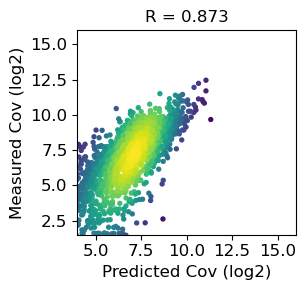

tissue = 'RNA:4sU:HEK293_2h_R1'
spearman r = 0.872
p = 0.0
n = 2470
(pearson r = 0.775)


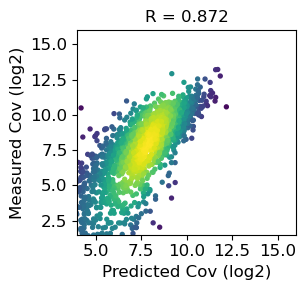

tissue = 'RNA:4sU:HEK293_4h_R1'
spearman r = 0.863
p = 0.0
n = 2470
(pearson r = 0.762)


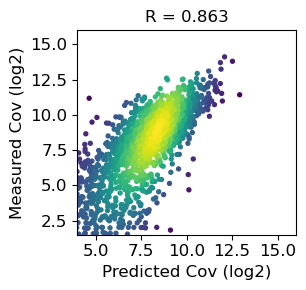

tissue = 'RNA:4sU:HEK293_8h_R1'
spearman r = 0.864
p = 0.0
n = 2470
(pearson r = 0.761)


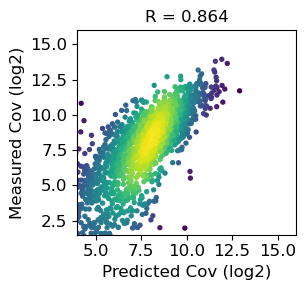

tissue = 'RNA:4sU:HEK293_12h_R1'
spearman r = 0.86
p = 0.0
n = 2470
(pearson r = 0.777)


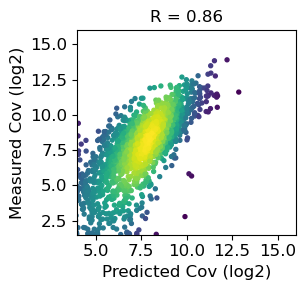

tissue = 'RNA:4sU:HEK293_24h_R1'
spearman r = 0.862
p = 0.0
n = 2470
(pearson r = 0.77)


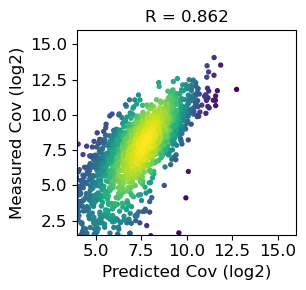

tissue = 'RNA:4sU:HEK293_SS_R1'
spearman r = 0.856
p = 0.0
n = 2470
(pearson r = 0.767)


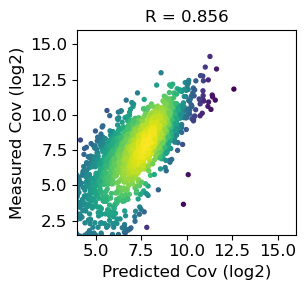

Evaluating for fold = 1
tissue = 'RNA:4sU:HEK293_1h_R1'
spearman r = 0.89
p = 0.0
n = 3030
(pearson r = 0.783)


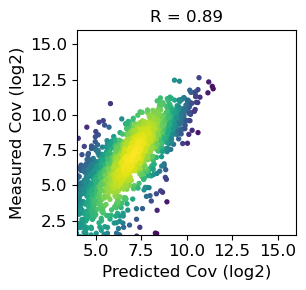

tissue = 'RNA:4sU:HEK293_2h_R1'
spearman r = 0.895
p = 0.0
n = 3030
(pearson r = 0.787)


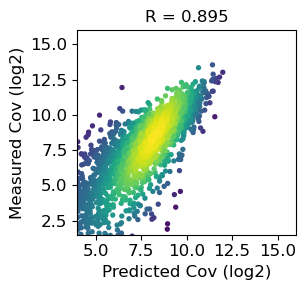

tissue = 'RNA:4sU:HEK293_4h_R1'
spearman r = 0.89
p = 0.0
n = 3030
(pearson r = 0.79)


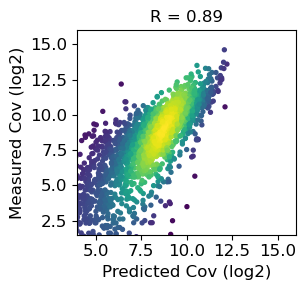

tissue = 'RNA:4sU:HEK293_8h_R1'
spearman r = 0.891
p = 0.0
n = 3030
(pearson r = 0.776)


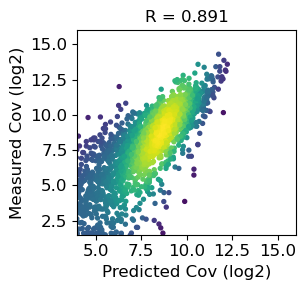

tissue = 'RNA:4sU:HEK293_12h_R1'
spearman r = 0.886
p = 0.0
n = 3030
(pearson r = 0.778)


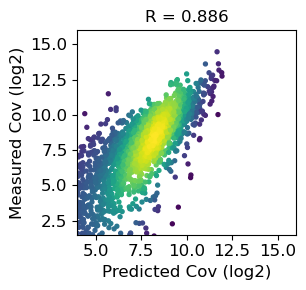

tissue = 'RNA:4sU:HEK293_24h_R1'
spearman r = 0.889
p = 0.0
n = 3030
(pearson r = 0.777)


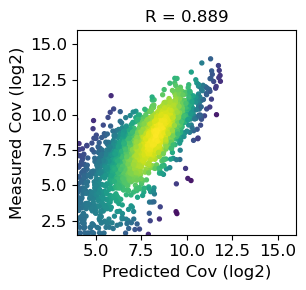

tissue = 'RNA:4sU:HEK293_SS_R1'
spearman r = 0.886
p = 0.0
n = 3030
(pearson r = 0.779)


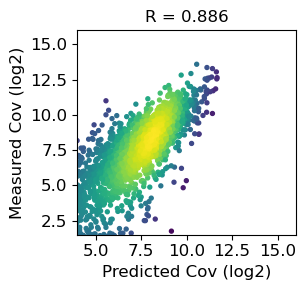

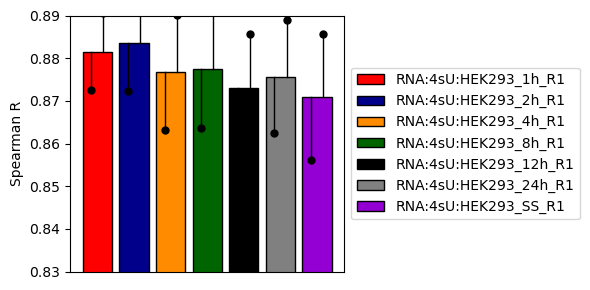

In [15]:
#Evaluate test set performance on held-out genes

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import spearmanr, pearsonr, gaussian_kde

fold_index = [0, 1]

save_figs = False
save_suffix = '_gene_expr_hek293_3_reps'

n_kde_sample = 500

rs_mat = np.zeros((len(tissues), 2), dtype='float32')

#Loop over folds
for fold_ix in fold_index :
    
    print("Evaluating for fold = " + str(fold_ix))
    
    for tissue_i, tissue in enumerate(tissues) :
        
        print("tissue = '" + tissue + "'")

        test_df = gene_df.loc[(~gene_df['test_fold'].isnull()) & (gene_df['test_fold'] == 'f' + str(fold_ix))].copy().reset_index(drop=True)

        #Pool predictions / measurements across tissues or cell types
        test_df['cov_pred'] = test_df[tissue + '_pred']
        test_df['cov_true'] = test_df[tissue + '_true']
        
        test_df = test_df.loc[~(np.isnan(test_df['cov_pred']) | np.isinf(test_df['cov_pred']))].copy().reset_index(drop=True)
        test_df = test_df.loc[~(np.isnan(test_df['cov_true']) | np.isinf(test_df['cov_true']))].copy().reset_index(drop=True)

        #Compare predicted vs. measured gene exon span coverage (derived from RNA-seq tracks)

        cov_pred = np.log2(test_df['cov_pred'].values + 1e-6)
        cov_true = np.log2(test_df['cov_true'].values + 1e-6)

        sample_index = np.arange(len(test_df), dtype='int32')
        np.random.shuffle(sample_index)
        sample_index = sample_index[:n_kde_sample]

        vals = np.concatenate([
            np.copy(cov_pred)[None, :],
            np.copy(cov_true)[None, :],
        ], axis=0)

        gkernel = gaussian_kde(vals[:, sample_index])(vals)

        rs_val, p_val = spearmanr(cov_pred, cov_true)
        rp_val, p_val = pearsonr(cov_pred, cov_true)

        rs_mat[tissue_i, fold_ix] = rs_val

        print("spearman r = " + str(round(rs_val, 3)))
        print("p = " + str(p_val))
        print("n = " + str(len(test_df)))

        print("(pearson r = " + str(round(rp_val, 3)) + ")")

        #Plot as density KDE
        f = None
        if not save_figs :
            f = plt.figure(figsize=(3, 3))
        else :
            f = plt.figure(figsize=(3, 3), dpi=600)

        plt.scatter(cov_pred, cov_true, s=8, c=gkernel, cmap='viridis', rasterized=True)

        plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
        plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.xlim(4, 16)
        plt.ylim(1.5, 16)

        plt.xlabel("Predicted Cov (log2)", fontsize=12)
        plt.ylabel("Measured Cov (log2)", fontsize=12)

        plt.title(label="R = " + str(round(rs_val, 3)))

        plt.tight_layout()

        if save_figs and fold_ix == 0 :
            plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_kde.png', dpi=600)
            plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_kde.pdf')
            #plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_kde.eps')

        plt.show()

#Plot performance summary (4-fold CV); with individual fold performance as dots
f = plt.figure(figsize=(6, 3)) #, dpi=300

model_colors = ['red', 'darkblue', 'darkorange', 'darkgreen', 'black', 'gray', 'darkviolet']

model_names = tissues

for i in range(rs_mat.shape[0]) :
    rs_mean = np.mean(rs_mat[i, :])
    plt.bar([i], rs_mean, width=0.8, edgecolor='black', color=model_colors[i], linewidth=1, zorder=0, label=model_names[i])
    
    for j in range(rs_mat.shape[1]) :
        plt.plot([
            i + (j+1) * (1. / (rs_mat.shape[1] + 1.)) - 0.5,
            i + (j+1) * (1. / (rs_mat.shape[1] + 1.)) - 0.5
        ], [rs_mean, rs_mat[i, j]], linewidth=1, color='black', linestyle='-', zorder=1)
        
        plt.scatter([
            i + (j+1) * (1. / (rs_mat.shape[1] + 1.)) - 0.5
        ], [rs_mat[i, j]], edgecolor='black', linewidth=1, color='black', s=25, zorder=2)

plt.xticks([], [])
plt.yticks(fontsize=10)

plt.ylabel("Spearman R", fontsize=10)

plt.ylim(0.83, 0.89)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

if save_figs :
    plt.savefig('borzoi_v2_cov' + save_suffix + '_bars.png', dpi=600)
    plt.savefig('borzoi_v2_cov' + save_suffix + '_bars.eps')

plt.show()


In [14]:
gene_df

,chrom,gene_id,strand,test_fold,RNA:4sU:HEK293_1h_R1_pred,RNA:4sU:HEK293_1h_R1_true,RNA:4sU:HEK293_2h_R1_pred,RNA:4sU:HEK293_2h_R1_true,RNA:4sU:HEK293_4h_R1_pred,RNA:4sU:HEK293_4h_R1_true,RNA:4sU:HEK293_8h_R1_pred,RNA:4sU:HEK293_8h_R1_true,RNA:4sU:HEK293_12h_R1_pred,RNA:4sU:HEK293_12h_R1_true,RNA:4sU:HEK293_24h_R1_pred,RNA:4sU:HEK293_24h_R1_true,RNA:4sU:HEK293_SS_R1_pred,RNA:4sU:HEK293_SS_R1_true
0,chr1,ENSG00000186092.7,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,ENSG00000284733.2,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,ENSG00000284662.2,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,ENSG00000187634.13,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,ENSG00000188976.11,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19665,chrM,ENSG00000212907.2,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19666,chrM,ENSG00000198886.2,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19667,chrM,ENSG00000198786.2,+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19668,chrM,ENSG00000198695.2,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Evaluating for fold = 0
spearman r = 0.628
p = 9.687876551523021e-203
n = 2470
(pearson r = 0.621)


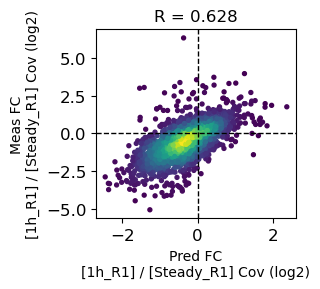

spearman r = 0.623
p = 9.158056547132745e-189
n = 2470
(pearson r = 0.6)


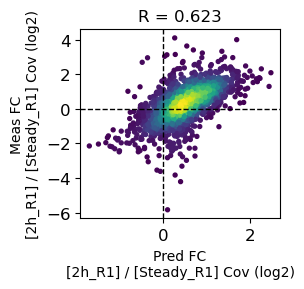

spearman r = 0.617
p = 4.2962170214246685e-170
n = 2470
(pearson r = 0.572)


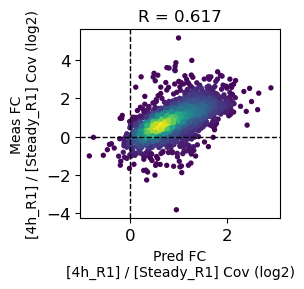

spearman r = 0.452
p = 9.71187131843329e-70
n = 2470
(pearson r = 0.385)


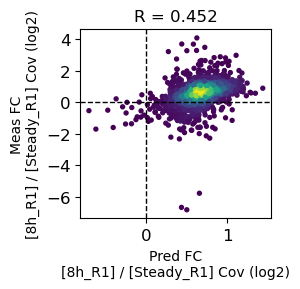

spearman r = 0.532
p = 6.94523002423955e-65
n = 2470
(pearson r = 0.373)


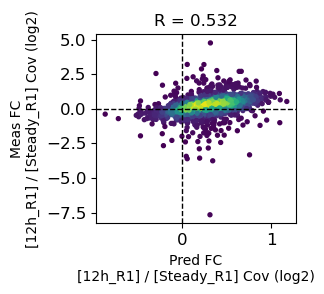

spearman r = 0.437
p = 1.7187708681720862e-46
n = 2470
(pearson r = 0.318)


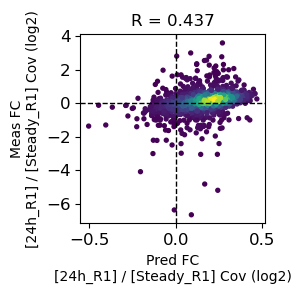

Evaluating for fold = 1
spearman r = 0.63
p = 1.6562549876851833e-248
n = 3030
(pearson r = 0.623)


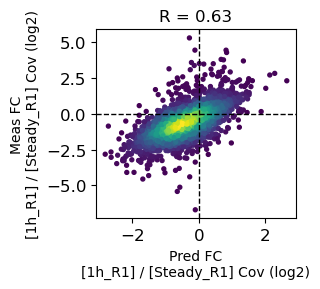

spearman r = 0.607
p = 2.730660465594885e-202
n = 3030
(pearson r = 0.57)


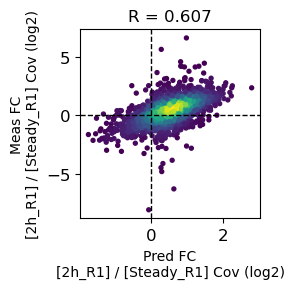

spearman r = 0.622
p = 3.05786023693399e-207
n = 3030
(pearson r = 0.573)


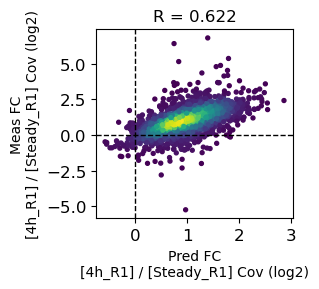

spearman r = 0.45
p = 2.3091794354450864e-101
n = 3030
(pearson r = 0.419)


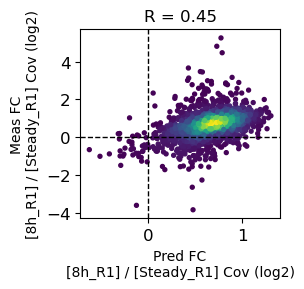

spearman r = 0.557
p = 1.077537325246684e-113
n = 3030
(pearson r = 0.443)


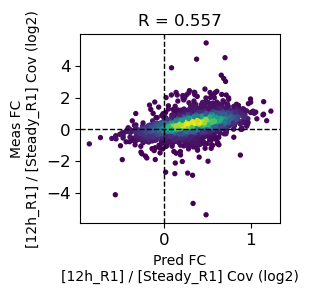

spearman r = 0.426
p = 1.3950513234120847e-33
n = 3030
(pearson r = 0.246)


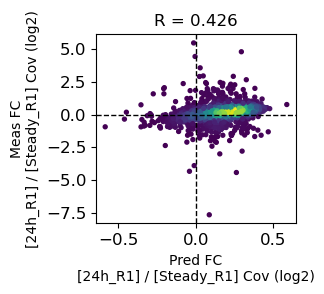

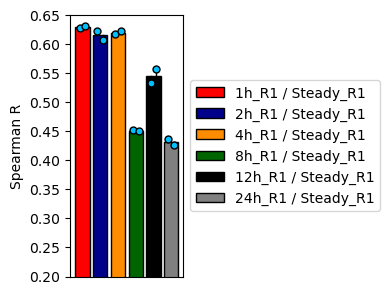

In [15]:
#Evaluate differential (tissue-specific) expression on held-out test genes

import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr, gaussian_kde

fold_index = [0, 1]

tissue_pairs = [
    ['RNA:4sU:HEK293_1h_R1', 'RNA:4sU:HEK293_SS_R1'],
    ['RNA:4sU:HEK293_2h_R1', 'RNA:4sU:HEK293_SS_R1'],
    ['RNA:4sU:HEK293_4h_R1', 'RNA:4sU:HEK293_SS_R1'],
    ['RNA:4sU:HEK293_8h_R1', 'RNA:4sU:HEK293_SS_R1'],
    ['RNA:4sU:HEK293_12h_R1', 'RNA:4sU:HEK293_SS_R1'],
    ['RNA:4sU:HEK293_24h_R1', 'RNA:4sU:HEK293_SS_R1'],
]

rs_mat = np.zeros((len(tissue_pairs), 2), dtype='float32')

#Loop over folds
for fold_ix in fold_index :
    
    print("Evaluating for fold = " + str(fold_ix))

    test_df = gene_df.loc[(~gene_df['test_fold'].isnull()) & (gene_df['test_fold'] == 'f' + str(fold_ix))].copy().reset_index(drop=True)
    
    #Compare predicted vs. measured tissue-specific expression

    for tissue_pair_i, tissue_pair in enumerate(tissue_pairs) :
        
        tissue_df = test_df.copy().reset_index(drop=True)
        
        [tissue_1, tissue_2] = tissue_pair
        
        tissue_df['cov_1_pred'] = tissue_df[tissue_1 + '_pred']
        tissue_df['cov_1_true'] = tissue_df[tissue_1 + '_true']
        
        tissue_df['cov_2_pred'] = tissue_df[tissue_2 + '_pred']
        tissue_df['cov_2_true'] = tissue_df[tissue_2 + '_true']
        
        tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_1_pred']) | np.isinf(tissue_df['cov_1_pred'])) | (tissue_df['cov_1_pred'] == 0.))].copy().reset_index(drop=True)
        tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_1_true']) | np.isinf(tissue_df['cov_1_true'])) | (tissue_df['cov_1_true'] == 0.))].copy().reset_index(drop=True)
        tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_2_pred']) | np.isinf(tissue_df['cov_2_pred'])) | (tissue_df['cov_2_pred'] == 0.))].copy().reset_index(drop=True)
        tissue_df = tissue_df.loc[~((np.isnan(tissue_df['cov_2_true']) | np.isinf(tissue_df['cov_2_true'])) | (tissue_df['cov_2_true'] == 0.))].copy().reset_index(drop=True)

        cov_pred = np.log2((tissue_df['cov_1_pred'] / tissue_df['cov_2_pred'].values).values + 1e-6)
        cov_true = np.log2((tissue_df['cov_1_true'] / tissue_df['cov_2_true'].values).values + 1e-6)

        sample_index = np.arange(len(tissue_df), dtype='int32')
        np.random.shuffle(sample_index)
        sample_index = sample_index[:n_kde_sample]

        vals = np.concatenate([
            np.copy(cov_pred)[None, :],
            np.copy(cov_true)[None, :],
        ], axis=0)

        gkernel = gaussian_kde(vals[:, sample_index])(vals)

        rs_val, p_val = spearmanr(cov_pred, cov_true)
        rp_val, p_val = pearsonr(cov_pred, cov_true)
        
        rs_mat[tissue_pair_i, fold_ix] = rs_val

        print("spearman r = " + str(round(rs_val, 3)))
        print("p = " + str(p_val))
        print("n = " + str(len(test_df)))

        print("(pearson r = " + str(round(rp_val, 3)) + ")")

        #Plot as density KDE
        f = None
        if not save_figs :
            f = plt.figure(figsize=(3, 3))
        else :
            f = plt.figure(figsize=(3, 3), dpi=600)

        plt.scatter(cov_pred, cov_true, s=8, c=gkernel, cmap='viridis', rasterized=True)

        plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
        plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        #plt.xlim(-2, 5)
        #plt.ylim(-2, 5)

        plt.xlabel("Pred FC\n[" + tissue_1.split("HEK293_")[1].replace('SS', 'Steady') + "] / [" + tissue_2.split("HEK293_")[1].replace('SS', 'Steady') + "] Cov (log2)", fontsize=10)
        plt.ylabel("Meas FC\n[" + tissue_1.split("HEK293_")[1].replace('SS', 'Steady') + "] / [" + tissue_2.split("HEK293_")[1].replace('SS', 'Steady') + "] Cov (log2)", fontsize=10)
        
        plt.title(label="R = " + str(round(rs_val, 3)))

        plt.tight_layout()
        
        if save_figs and fold_ix == 0 :
            plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_tissue_' + str(tissue_pair_i) + '_kde.png', dpi=600)
            plt.savefig('borzoi_v2_cov' + save_suffix + '_fold_' + str(fold_ix) + '_tissue_' + str(tissue_pair_i) + '_kde.pdf')

        plt.show()

#Plot performance summary (4-fold CV); with individual fold performance as dots
f = plt.figure(figsize=(4, 3)) #, dpi=300

model_colors = ['red', 'darkblue', 'darkorange', 'darkgreen', 'black', 'gray']

model_names = [tissue_pair[0].split("HEK293_")[1].replace('SS', 'Steady') + " / " + tissue_pair[1].split("HEK293_")[1].replace('SS', 'Steady') for tissue_pair in tissue_pairs]

for i in range(rs_mat.shape[0]) :
    rs_mean = np.mean(rs_mat[i, :])
    plt.bar([i], rs_mean, width=0.8, edgecolor='black', color=model_colors[i], linewidth=1, zorder=0, label=model_names[i])
    
    for j in range(rs_mat.shape[1]) :
        plt.plot([
            i + (j+1) * (1. / (rs_mat.shape[1] + 1.)) - 0.5,
            i + (j+1) * (1. / (rs_mat.shape[1] + 1.)) - 0.5
        ], [rs_mean, rs_mat[i, j]], linewidth=1, color='black', linestyle='-', zorder=1)
        
        plt.scatter([
            i + (j+1) * (1. / (rs_mat.shape[1] + 1.)) - 0.5
        ], [rs_mat[i, j]], edgecolor='black', linewidth=1, color='deepskyblue', s=25, zorder=2)

plt.xticks([], [])
plt.yticks(fontsize=10)

plt.ylabel("Spearman R", fontsize=10)

plt.ylim(0.2, 0.65)

plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()

if save_figs :
    plt.savefig('borzoi_v2_cov' + save_suffix + '_tissues_bars.png', dpi=600)
    plt.savefig('borzoi_v2_cov' + save_suffix + '_tissues_bars.eps')

plt.show()


In [16]:
#Get subset of genes with nonzero predictions / measurements

fold_ix = 0

min_s = 0.
min_e = 0.

test_df = gene_df.loc[(~gene_df['test_fold'].isnull()) & (gene_df['test_fold'] == 'f' + str(fold_ix))].copy().reset_index(drop=True)
test_df = test_df.loc[(test_df['RNA:4sU:HEK293_1h_R1_true'] > min_s) & (test_df['RNA:4sU:HEK293_24h_R1_true'] > min_e)].copy().reset_index(drop=True)
test_df['gene_base'] = test_df['gene_id'].apply(lambda x: x.split(".")[0])

print("len(test_df) = " + str(len(test_df)))


len(test_df) = 1908


In [17]:
#Calculate normalized time-course expression values

test_df_pred = test_df[[
    'gene_id',
    'RNA:4sU:HEK293_1h_R1_pred',
    'RNA:4sU:HEK293_2h_R1_pred',
    'RNA:4sU:HEK293_4h_R1_pred',
    'RNA:4sU:HEK293_8h_R1_pred',
    'RNA:4sU:HEK293_12h_R1_pred',
    'RNA:4sU:HEK293_24h_R1_pred',
]].copy()

test_df_true = test_df[[
    'gene_id',
    'RNA:4sU:HEK293_1h_R1_true',
    'RNA:4sU:HEK293_2h_R1_true',
    'RNA:4sU:HEK293_4h_R1_true',
    'RNA:4sU:HEK293_8h_R1_true',
    'RNA:4sU:HEK293_12h_R1_true',
    'RNA:4sU:HEK293_24h_R1_true',
]].copy()

pred_vals = test_df_pred.values[:, 1:]
true_vals = test_df_true.values[:, 1:]

#Normalize by GAPDH expression values
pred_vals = pred_vals * (1. / np.array([[66.6, 153.0, 335.1, 320.8, 388.3, 389.3]]))
true_vals = true_vals * (1. / np.array([[66.6, 153.0, 335.1, 320.8, 388.3, 389.3]]))

pred_vals = pred_vals / np.max(pred_vals, axis=1, keepdims=True)
true_vals = true_vals / np.max(true_vals, axis=1, keepdims=True)

test_df_pred['RNA:4sU:HEK293_1h_R1_pred'] = pred_vals[:, 0] 
test_df_pred['RNA:4sU:HEK293_2h_R1_pred'] = pred_vals[:, 1]
test_df_pred['RNA:4sU:HEK293_4h_R1_pred'] = pred_vals[:, 2]
test_df_pred['RNA:4sU:HEK293_8h_R1_pred'] = pred_vals[:, 3]
test_df_pred['RNA:4sU:HEK293_12h_R1_pred'] = pred_vals[:, 4]
test_df_pred['RNA:4sU:HEK293_24h_R1_pred'] = pred_vals[:, 5]

test_df_true['RNA:4sU:HEK293_1h_R1_true'] = true_vals[:, 0] 
test_df_true['RNA:4sU:HEK293_2h_R1_true'] = true_vals[:, 1]
test_df_true['RNA:4sU:HEK293_4h_R1_true'] = true_vals[:, 2]
test_df_true['RNA:4sU:HEK293_8h_R1_true'] = true_vals[:, 3]
test_df_true['RNA:4sU:HEK293_12h_R1_true'] = true_vals[:, 4]
test_df_true['RNA:4sU:HEK293_24h_R1_true'] = true_vals[:, 5]


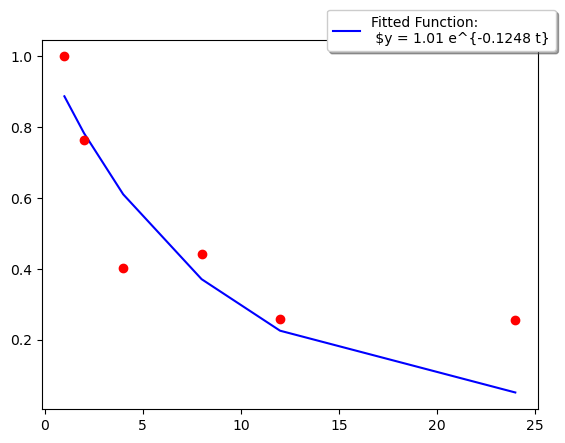

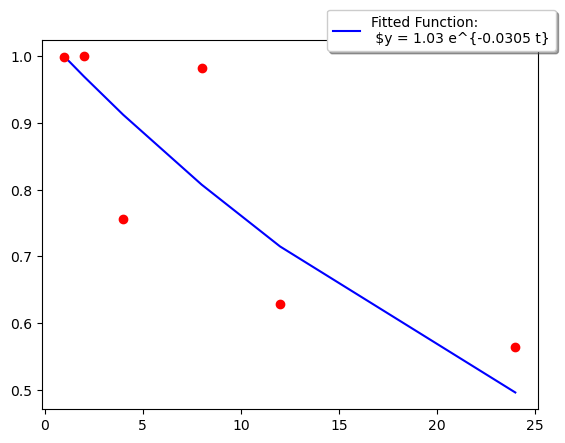

In [18]:
#Half-life fitting functions

import scipy as sp
import scipy.optimize

def model_func(t, A, K) :
    return A * np.exp(-K * t)

def cost(params, t, y) :
    
    A, K = params
    y_hat = model_func(t, A, K)
    
    return np.mean((y - y_hat)**2) + 0.001 * np.log(K)**2

def fit_exp_nonlinear(t, y, method='minimize') :
    
    A, K = 0., 0.
    if method == 'minimize' :
        res = sp.optimize.minimize(
            cost,
            args=(t, y),
            x0=[1., 1.],
            bounds=[(1e-3, 2.), (1e-3, 1.)],
            options={'maxiter' : 1000, 'gtol' : 1e-7, 'eps' : 1e-5}
        )
        A, K = res.x
    elif method == 'curve_fit' :
        opt_parms, parm_cov = sp.optimize.curve_fit(model_func, t, y, maxfev=2000)
        A, K = opt_parms
    
    return A, K

def plot(ax, t, noisy_y, fit_y, fit_parms) :
    
    A, K = fit_parms

    ax.plot(t, fit_y, 'b-',
      label='Fitted Function:\n $y = %0.2f e^{-%0.4f t}' % (A, K))
    ax.plot(t, noisy_y, 'ro')
    ax.legend(bbox_to_anchor=(1.05, 1.1), fancybox=True, shadow=True)

t = np.array([1, 2, 4, 8, 12, 24], dtype='float32')

example_ix = 1

method = 'minimize'

row_p = test_df_pred.iloc[example_ix]
row_t = test_df_true.iloc[example_ix]

y_p = np.array(row_p.values[1:], dtype='float32')
y_t = np.array(row_t.values[1:], dtype='float32')

A_p, K_p = fit_exp_nonlinear(t, y_p, method=method)
A_t, K_t = fit_exp_nonlinear(t, y_t, method=method)

fit_y_p = model_func(t, A_p, K_p)
fit_y_t = model_func(t, A_t, K_t)

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
plot(ax1, t, y_p, fit_y_p, (A_p, K_p))
plt.show()

fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
plot(ax1, t, y_t, fit_y_t, (A_t, K_t))
plt.show()


In [19]:
#Fit half-life curves for all genes

t = np.array([1, 2, 4, 8, 12, 24], dtype='float32')

eps = 0.#1e-1

half_life_preds = []
half_life_trues = []
for i, [[_, row_p], [_, row_t]] in enumerate(zip(test_df_pred.iterrows(), test_df_true.iterrows())) :
    
    if i % 100 == 0 :
        print('Fitting hl curve for gene = ' + str(i) + '...')

    y_p = np.array(row_p.values[1:], dtype='float32')
    y_t = np.array(row_t.values[1:], dtype='float32')

    A_p, K_p = fit_exp_nonlinear(t, y_p, method=method)
    A_t, K_t = fit_exp_nonlinear(t, y_t, method=method)
    
    half_life_preds.append(K_p)
    half_life_trues.append(K_t)

test_df['hl_pred'] = np.log2(np.array(half_life_preds) + eps)
test_df['hl_true'] = np.log2(np.array(half_life_trues) + eps)


Fitting hl curve for gene = 0...
Fitting hl curve for gene = 100...
Fitting hl curve for gene = 200...
Fitting hl curve for gene = 300...
Fitting hl curve for gene = 400...
Fitting hl curve for gene = 500...
Fitting hl curve for gene = 600...
Fitting hl curve for gene = 700...
Fitting hl curve for gene = 800...
Fitting hl curve for gene = 900...
Fitting hl curve for gene = 1000...
Fitting hl curve for gene = 1100...
Fitting hl curve for gene = 1200...
Fitting hl curve for gene = 1300...
Fitting hl curve for gene = 1400...
Fitting hl curve for gene = 1500...
Fitting hl curve for gene = 1600...
Fitting hl curve for gene = 1700...
Fitting hl curve for gene = 1800...
Fitting hl curve for gene = 1900...


In [20]:
#Load and append HL measurements from Saluki paper

hl_df = pd.read_csv('../../half-life/all_HLs_human_PC1.txt', sep='\t')

print("len(hl_df) = " + str(len(hl_df)))

test_df_saluki = test_df.join(hl_df.set_index('ensembl_gene_id'), on='gene_base', how='inner').copy().reset_index(drop=True)
test_df_saluki = test_df_saluki[['gene_base', 'hl_pred', 'hl_true', 'human_PC1']]

test_df_saluki = test_df_saluki.loc[(~test_df_saluki['hl_pred'].isnull()) & (~test_df_saluki['hl_true'].isnull())].copy().reset_index(drop=True)

print("len(test_df_saluki) = " + str(len(test_df_saluki)))


len(hl_df) = 13921
len(test_df_saluki) = 1637


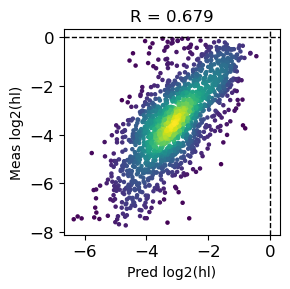

In [21]:
#Plot scatter (predictions vs observations)

df = test_df_saluki

sample_index = np.arange(len(df), dtype='int32')
np.random.shuffle(sample_index)
sample_index = sample_index[:n_kde_sample]

y_pred = np.array(df['hl_pred'].values, dtype='float32')
y_true = np.array(df['hl_true'].values, dtype='float32')

vals = np.concatenate([
    np.copy(y_pred)[None, :],
    np.copy(y_true)[None, :],
], axis=0)

gkernel = gaussian_kde(vals[:, sample_index])(vals)

rs_val, _ = spearmanr(y_pred, y_true)

f = plt.figure(figsize=(3, 3))

#plt.scatter(y_pred, y_true, s=5, c='black', alpha=0.25)
plt.scatter(y_pred, y_true, s=5, c=gkernel, cmap='viridis', rasterized=True)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#plt.xlim(-6.0, 0.5)
#plt.ylim(-6.5, 0.5)

plt.xlabel("Pred log2(hl)", fontsize=10)
plt.ylabel("Meas log2(hl)", fontsize=10)

plt.title(label="R = " + str(round(rs_val, 3)))

plt.tight_layout()

plt.show()


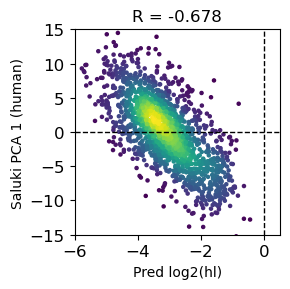

In [22]:
#Plot scatter (predictions vs Saluki PCA 1)

df = test_df_saluki

sample_index = np.arange(len(df), dtype='int32')
np.random.shuffle(sample_index)
sample_index = sample_index[:n_kde_sample]

y_pred = np.array(df['hl_pred'].values, dtype='float32')
y_true = np.array(df['human_PC1'].values, dtype='float32')

vals = np.concatenate([
    np.copy(y_pred)[None, :],
    np.copy(y_true)[None, :],
], axis=0)

gkernel = gaussian_kde(vals[:, sample_index])(vals)

rs_val, _ = spearmanr(y_pred, y_true)

f = plt.figure(figsize=(3, 3))

#plt.scatter(y_pred, y_true, s=5, c='black', alpha=0.25)
plt.scatter(y_pred, y_true, s=5, c=gkernel, cmap='viridis', rasterized=True)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(-6.0, 0.5)
plt.ylim(-15, 15)

plt.xlabel("Pred log2(hl)", fontsize=10)
plt.ylabel("Saluki PCA 1 (human)", fontsize=10)

plt.title(label="R = " + str(round(rs_val, 3)))

plt.tight_layout()

plt.show()


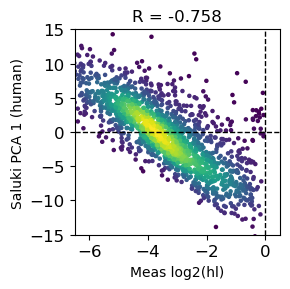

In [23]:
#Plot scatter (observations vs Saluki PCA 1)

df = test_df_saluki

sample_index = np.arange(len(df), dtype='int32')
np.random.shuffle(sample_index)
sample_index = sample_index[:n_kde_sample]

y_pred = np.array(df['hl_true'].values, dtype='float32')
y_true = np.array(df['human_PC1'].values, dtype='float32')

vals = np.concatenate([
    np.copy(y_pred)[None, :],
    np.copy(y_true)[None, :],
], axis=0)

gkernel = gaussian_kde(vals[:, sample_index])(vals)

rs_val, _ = spearmanr(y_pred, y_true)

f = plt.figure(figsize=(3, 3))

#plt.scatter(y_pred, y_true, s=5, c='black', alpha=0.25)
plt.scatter(y_pred, y_true, s=5, c=gkernel, cmap='viridis', rasterized=True)

plt.axvline(x=0, color='black', linewidth=1, linestyle='--')
plt.axhline(y=0, color='black', linewidth=1, linestyle='--')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.xlim(-6.5, 0.5)
plt.ylim(-15, 15)

plt.xlabel("Meas log2(hl)", fontsize=10)
plt.ylabel("Saluki PCA 1 (human)", fontsize=10)

plt.title(label="R = " + str(round(rs_val, 3)))

plt.tight_layout()

plt.show()
